In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.cluster import DBSCAN
#import analyzeImage

In [15]:
paramsFile = open('test.txt', 'w')
paramsFile.write(
"""Debug ................ : 1
Image Count .......... : 5
Generate Images ...... : 0
Image Width .......... : 1000
Image Height ......... : 1000
PSF Sigma ............ : 1.0
Object Brightness .... : 2500.0
Object Initial x ..... : 150.0
Object Initial y ..... : 100.0
Velocity x ........... : 200.0
Velocity y ........... : -250.0
Background Level ..... : 1024.0
Background Sigma ..... : 32.0
Mask Threshold ....... : 40.0
Mask Penalty ......... : -0.008
Angles to Search ..... : 30
Velocities to Search . : 15
Minimum Velocity ..... : 270.0
Maximum Velocity ..... : 600.0
Write to file ........ : 1
Source Images Path ... : ../images/chip_0/
Psi Images Path ...... : ../output-images/psi/
Phi Images Path....... : ../output-images/phi/
""")
paramsFile.close()

In [21]:
os.system("../code/gpu/debug/clearImages.sh")
os.system("../code/gpu/debug/CudaTracker")

34304

In [21]:
results = np.genfromtxt('../code/gpu/debug/resultsOld.txt', names=True)

In [3]:
print(results)

[(1791.0, 167.0, 0.0, 0.0, -13.004, 413.796, 48.308, 0.0)
 (1792.0, 169.0, 0.0, 0.0, -24.677, 392.225, 48.275, 0.0)
 (1792.0, 168.0, 0.0, 0.0, -25.242, 401.207, 48.079, 0.0) ...,
 (1622.0, 620.0, 0.0, 0.0, 494.832, -78.374, 25.986, 0.0)
 (688.0, 1621.0, 0.0, 0.0, -56.4, 446.452, 25.986, 0.0)
 (213.0, 867.0, 0.0, 0.0, -204.78, 180.538, 25.986, 0.0)]


In [2]:
real_image_path = "../code/gpu/images/chip_0/"

In [3]:
image_mjd = []

for filename in sorted(os.listdir(real_image_path)):
    hdulist = fits.open(os.path.join(real_image_path, filename))
    image_mjd.append(hdulist[0].header['MJD'])

image_mjd = np.array(image_mjd)
image_times = image_mjd - image_mjd[0]
image_times*=24.


In [4]:
hdulist = fits.open(os.path.join(real_image_path, os.listdir(real_image_path)[0]))
num_images = len(os.listdir(real_image_path))
image_shape = np.shape(hdulist[1].data)
im_array = np.zeros((num_images, image_shape[0], image_shape[1]))


for idx, filename in list(enumerate(sorted(os.listdir(real_image_path)))):

    #print str('Loaded ' + filename)

    image_file = os.path.join(real_image_path, filename)
    hdulist = fits.open(image_file)
    im_array[idx] = hdulist[1].data#*mask


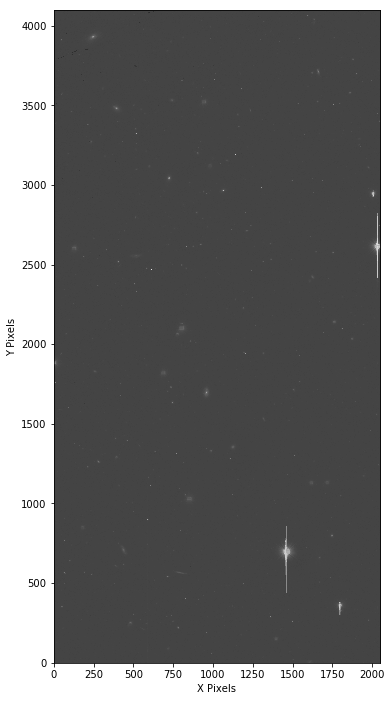

In [5]:
fig = plt.figure(figsize=(12,12))
plt.imshow(im_array[2], origin='lower', cmap=plt.cm.Greys_r)
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.show()

In [6]:
def calcCenters(startLocArr, velArr, timeArr):

    startLocArr = np.array(startLocArr)
    velArr = np.array(velArr)
    centerArr = []
    for time in timeArr:
        centerArr.append(startLocArr + (velArr*time))
    return np.array(centerArr)

In [7]:
def createPostageStamp(imageArray, objectStartArr, velArr,
                           timeArr, stamp_width):

        """
        Create postage stamp image coadds of potential objects traveling along
        a trajectory.

        Parameters
        ----------

        imageArray: numpy array, required
        The masked input images.

        objectStartArr: numpy array, required
        An array with the starting location of the object in pixels.

        velArr: numpy array, required
        The x,y velocity in pixels/hr. of the object trajectory.

        timeArr: numpy array, required
        The time in hours of each image starting from 0 at the first image.

        stamp_width: numpy array or list, [2], required
        The row, column dimensions of the desired output image.

        Returns
        -------

        stampImage: numpy array
        The coadded postage stamp.

        singleImagesArray: numpy array
        The postage stamps that were added together to create the coadd.
        """

        singleImagesArray = []
        stampWidth = np.array(stamp_width, dtype=int)
        #print stampWidth
        stampImage = np.zeros(stampWidth)
        if len(np.shape(imageArray)) < 3:
            imageArray = [imageArray]

        measureCoords = calcCenters(np.array(objectStartArr), np.array(velArr), timeArr)

        if len(np.shape(measureCoords)) < 2:
            measureCoords = [measureCoords]
        for centerCoords in measureCoords:
            if (centerCoords[0] + stampWidth[0]/2 + 1) > np.shape(imageArray[0])[1]:
                raise ValueError('The boundaries of your postage stamp for one of the images go off the edge')
            elif (centerCoords[0] - stampWidth[0]/2) < 0:
                raise ValueError('The boundaries of your postage stamp for one of the images go off the edge')
            elif (centerCoords[1] + stampWidth[1]/2 + 1) > np.shape(imageArray[0])[0]:
                raise ValueError('The boundaries of your postage stamp for one of the images go off the edge')
            elif (centerCoords[1] - stampWidth[1]/2) < 0:
                raise ValueError('The boundaries of your postage stamp for one of the images go off the edge')

        i=0
        for image in imageArray:
            xmin = int(np.rint(measureCoords[i,1]-stampWidth[0]/2))
            xmax = int(xmin + stampWidth[0])
            ymin = int(np.rint(measureCoords[i,0]-stampWidth[1]/2))
            ymax = int(ymin + stampWidth[1])
            #print xmin, xmax, ymin, ymax
            stampImage += image[xmin:xmax, ymin:ymax]
            singleImagesArray.append(image[xmin:xmax, ymin:ymax])

            i+=1
        return stampImage, singleImagesArray

In [10]:
results[['t0_x', 't0_y']]

array([(596.0, 1849.0), (598.0, 1849.0), (1879.0, 2107.0), ...,
       (1370.0, 2797.0), (1407.0, 2798.0), (647.0, 1875.0)], 
      dtype=[('t0_x', '<f8'), ('t0_y', '<f8')])

In [19]:
stamp_count = 24
best_targets = range(stamp_count)
#best_targets

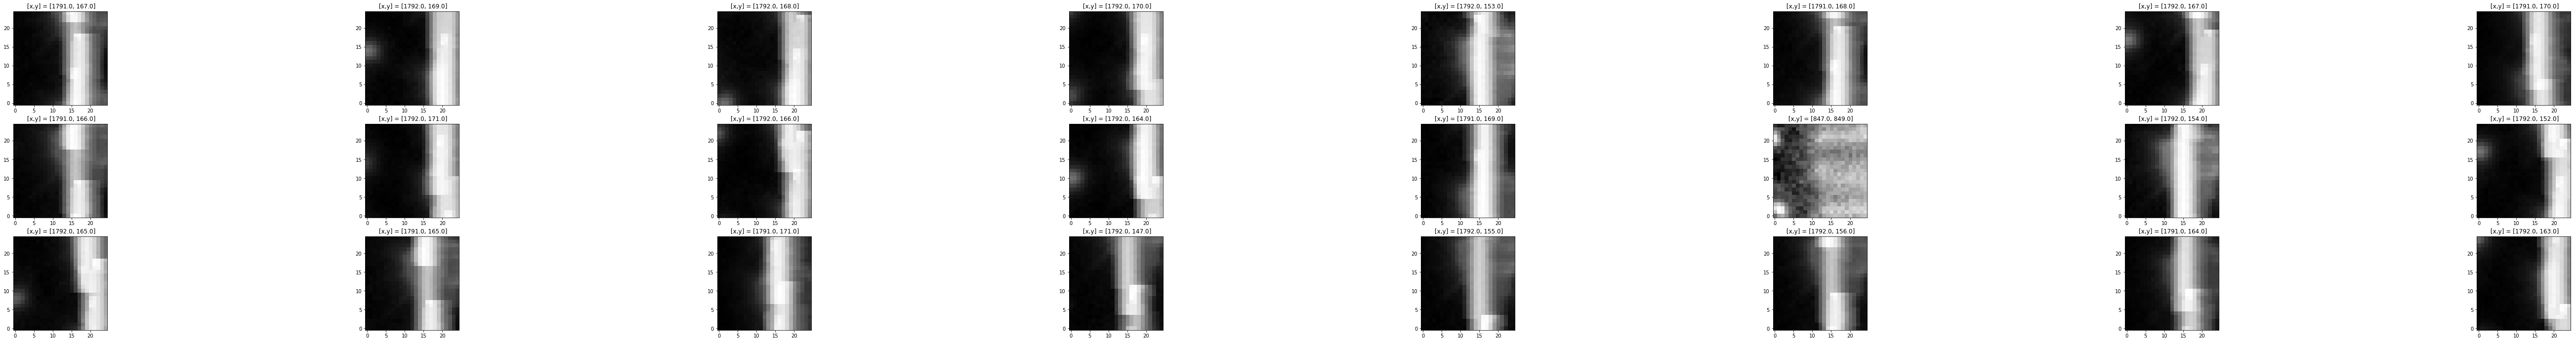

In [23]:
fig = plt.figure(figsize=(100,100))
i=0
for imNum in range(stamp_count):
    fig.add_subplot(stamp_count,8,imNum+1)
    try:
        plt.imshow(createPostageStamp(im_array, 
                                     list(results[['t0_x', 't0_y']][best_targets][imNum]),
                                     list(results[['v_x', 'v_y']][best_targets][imNum]),
                                     image_times, [25., 25.])[0],
                origin='lower', cmap=plt.cm.Greys_r, interpolation='None')
        plt.title(str(' [x,y] = ' + str(list(results[['t0_x', 't0_y']][best_targets][imNum]))))
    except:
        continue
#    plt.show()
#plt.tight_layout()
plt.show()